In [23]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas as pd

from sklearn.metrics import pairwise_distances

# Distances in High Dimension

We have said that high-dimensional Euclidean vector spaces "look" *very* different than $\mathbb{R}^{2}$ or $\mathbb{R}^{3}$. It's not immediately clear how we might quantify that. To start, let's ask how would we tell the difference between $\mathbb{R}$ and $\mathbb{R}^{2}$ or between $\mathbb{R}^{2}$ and $\mathbb{R}^{3}$ if we could not "see" them.

One approach would be to measure simple properties of them and then make plots of those properties.
The most basic property that we can compute are distances. In data science, we often compute distances to discriminiate between data points, i.e., we often consider that data points that are close belong to the same class, while points that are far apart might belong to different classes. While this is often true in low-dimensional space, this intuation can be misleading in high-dimensional spaces, as we will see later.

In this workbook, we will first uniformly select a point within the $\mathbb{R}^d$ unit ball (i.e., the set of $x$ where $\|x\|_2 \leq 1$), and investigate various properties of these points as the dimension $d$ gets large.

## Sampling from High-dimensional $\ell_2$ Balls

It's harder than you might think to sample points uniformly from a unit ball. (For a unit-$\ell_2$ ball that is. It is clearly much easier for a unit-$\ell_\infty$ ball.) Slight oversights could result in a bias towards points near the boundary, or near the center, etc. We won't get into this in too much detail; we just mention it, so that you are aware of it.

We will take the following approach:

1. Uniformly select a direction. 
We can do this by sampling from a standard normal distribtution in $\mathbb{R}^d$, which we know forms a ball in $\mathbb{R}^d$. (In particular, it is symmetric in all dimensions.) However, the issue with simply taking a point from a multivariate gaussian is that there is no bound. In principle, we could end up with a point $\|x\|_2 \gg 1$ (although, from what we know about tail bounds, we know that this is very unlikely); but we could very easily end up with a point with $\|x\|_2 > 1$. In addition, it is not uniformly distributed within the ball. Therefore, we take the point sampled from the standard normal distribution and normalize it, turning it into only the direction component. If you like, convince yourself that each possible direction is still equally likely to be selected.

2. Uniformly select a magnitude. 
We uniformly select a scalar from $[0, 1)$, but then take it to the $d$th root to allow for points to be uniformly distributed inside the unit ball.

In the following cell, we define a function that randomly samples $n$ points from within the $\mathbb{R}^d$ unit ball.

In [24]:
def sample_in_sphere(n, d):
    random_vec = np.random.randn(d, n)
    random_vec /= np.linalg.norm(random_vec, axis=0)
    random_magnitude = np.random.rand(n) ** (1/d)
    return (random_vec * random_magnitude).T

For instance, we can draw $m=1000$ random points in $\mathbb{R}^2$ as follows.

In [25]:
X = sample_in_sphere(n=1000, d=2)

Let us quickly varify that this function indeed samples points uniformly distributed inside the unit ball in $\mathbb{R}^2$. 

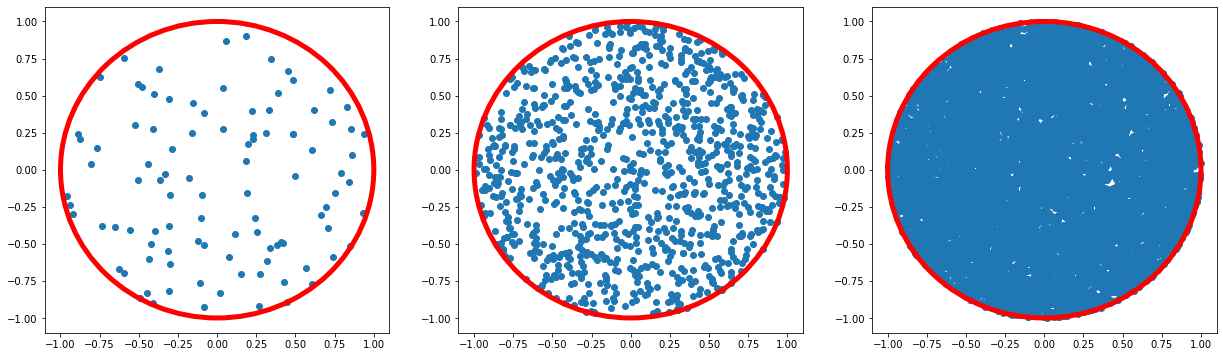

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21,6))

X = sample_in_sphere(100, 2)
axs[0].scatter(X[:,0],X[:,1])
axs[0].add_patch(plt.Circle((0, 0), radius=1, edgecolor='red', linewidth=5, facecolor='None'))

X = sample_in_sphere(1000, 2)
axs[1].scatter(X[:,0],X[:,1])
axs[1].add_patch(plt.Circle((0, 0), radius=1, edgecolor='red', linewidth=5, facecolor='None'))

X = sample_in_sphere(10000, 2)
axs[2].scatter(X[:,0],X[:,1])
axs[2].add_patch(plt.Circle((0, 0), radius=1, edgecolor='red', linewidth=5, facecolor='None'))

We can also visualize points in $\mathbb{R}^3$.

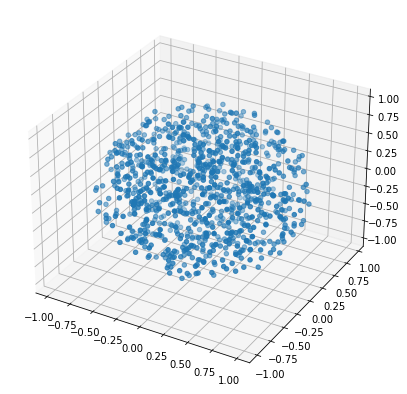

In [27]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
X = sample_in_sphere(1000, 3)
ax.scatter3D(X[:,0], X[:,1], X[:,2])

## Compute distances between high-dimensional points and the origin

Let's explore how distances between points uniformly sampled from inside the unit ball to the orgin varies as a function of number of dimensions. First let us visualize the distances in $\mathbb{R}^1$. 
In $\mathbb{R}^1$, we are essentially selecting points uniformly from the $[-1, 1]$ interval on a number line. And it is also easy to compute the distance to the orgin.  

In [35]:
distance = np.linalg.norm(sample_in_sphere(1, 1)-0)
print(distance)

0.19187418501567455


It is not very intersting to look only at the distance of a single random point to the origin, but fortunately we can sample a large number of points in no time and visualize the dinstances using a histogram. So let's do that.

(0.0, 1.0)

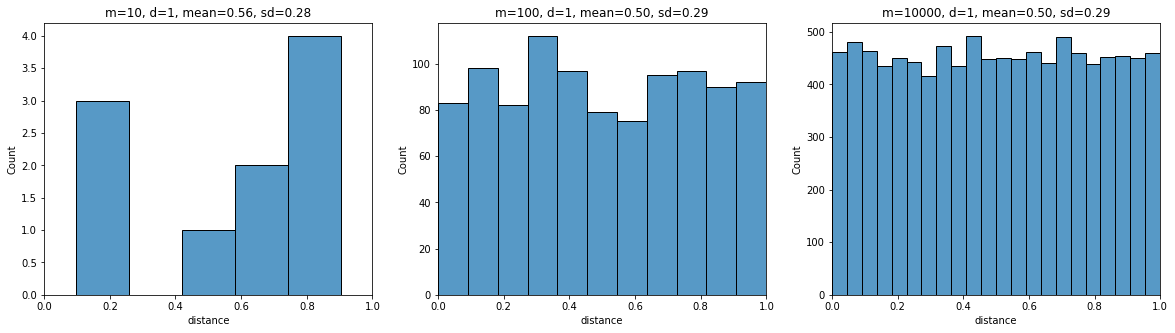

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

distance = np.linalg.norm(sample_in_sphere(10, 1)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[0], data=df, x="distance", kde=False)
axs[0].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(10, 1, np.mean(distance), np.var(distance)**0.5))
axs[0].set_xlim(0,1)

distance = np.linalg.norm(sample_in_sphere(1000, 1)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[1], data=df, x="distance", kde=False)
axs[1].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(100, 1, np.mean(distance), np.var(distance)**0.5))
axs[1].set_xlim(0,1)

distance = np.linalg.norm(sample_in_sphere(10000, 1)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[2], data=df, x="distance", kde=False)
axs[2].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(10000, 1, np.mean(distance), np.var(distance)**0.5))
axs[2].set_xlim(0,1)

We see that the count gradually gets more and more uniform, suggesting that the true probability is uniform.
In fact, it is. It should be easy to convince yourself that this is plausible since sampling uniformly from the unit ball in $\mathbb{R}^1$ is just sampling uniformly from $[-1,1]$.

Now let's repat the experiment with points sampled in $\mathbb{R}^2$.

(0.0, 1.0)

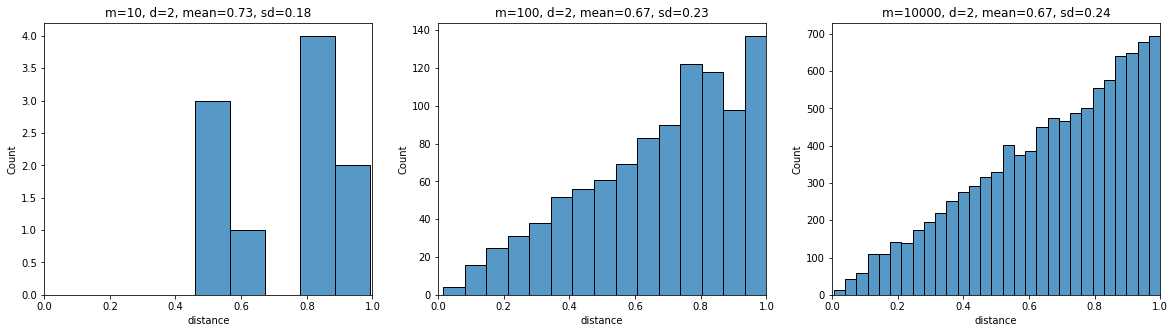

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

distance = np.linalg.norm(sample_in_sphere(10, 2)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[0], data=df, x="distance", kde=False)
axs[0].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(10, 2, np.mean(distance), np.var(distance)**0.5))
axs[0].set_xlim(0,1)

distance = np.linalg.norm(sample_in_sphere(1000, 2)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[1], data=df, x="distance", kde=False)
axs[1].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(100, 2, np.mean(distance), np.var(distance)**0.5))
axs[1].set_xlim(0,1)

distance = np.linalg.norm(sample_in_sphere(10000, 2)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[2], data=df, x="distance", kde=False)
axs[2].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(10000, 2, np.mean(distance), np.var(distance)**0.5))
axs[2].set_xlim(0,1)

Notice that you start to end up with disproportionately higher occurances of points with distances closer to one than zero from the origin, i.e., the count increases linearly with distance. This may be initially surprising. If we think about it, however, from the persepctive of simple calculus, it makes sense. To see this, imagine an annulus (or a "donut") with radii $r$ and $r+\delta$, for example plotted below:

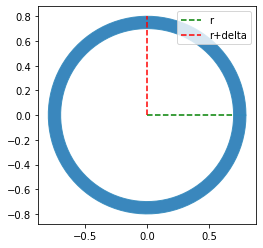

In [34]:
r = .7
delta = .1

n = 100
radii = [r, r+delta]

theta = np.linspace(0, 2*np.pi, n, endpoint=True)
xs = np.outer(radii, np.cos(theta))
ys = np.outer(radii, np.sin(theta))

xs[1,:] = xs[1,::-1]
ys[1,:] = ys[1,::-1]

ax = plt.subplot(111, aspect='equal')
ax.fill(np.ravel(xs), np.ravel(ys), edgecolor='#348ABD', alpha=.88)
ax.plot([0,r], [0,0], label='r', linestyle='--', color='green')
ax.plot([0,0], [0,r+delta], label='r+delta', linestyle='--', color='red')
ax.legend()
plt.show()

The area of this donut shape is 

$$
\pi (r+\delta)^2 - \pi r^2 = \pi (r^2 +2r\delta + \delta^2) - \pi r^2 = 2\pi r\delta +\pi\delta^2  
$$

Thus, for $\delta$ small and fixed, the area of this annulus grows as $r$ grows. Hence a larger fraction of the unit ball will be encompased in the regions near the edge of the circle, with larger radius. As we will see, this phenomenon gets more pronounced as we move to higher dimensions.


Let's see what happens in dimensions $10, 100$ and $1000$. (Even if these are harder to visualize or analyze mathematically, they are easy to analyze computationally.)

(0.0, 1.0)

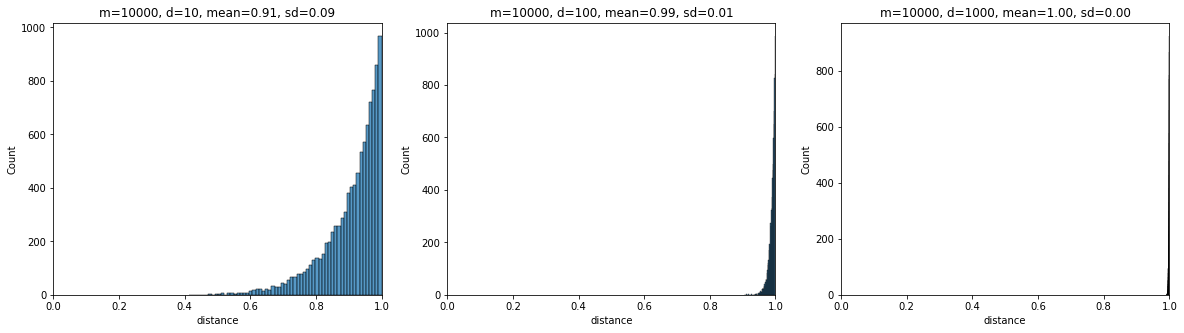

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

distance = np.linalg.norm(sample_in_sphere(10000, 10)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[0], data=df, x="distance", kde=False)
axs[0].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(10000, 10, np.mean(distance), np.var(distance)**0.5))
axs[0].set_xlim(0,1)

distance = np.linalg.norm(sample_in_sphere(10000, 100)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[1], data=df, x="distance", kde=False)
axs[1].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(10000, 100, np.mean(distance), np.var(distance)**0.5))
axs[1].set_xlim(0,1)

distance = np.linalg.norm(sample_in_sphere(10000, 1000)-0, axis=1)
df = pd.DataFrame(data={'distance': distance.flatten()})
sns.histplot(ax=axs[2], data=df, x="distance", kde=False)
axs[2].set_title('m=%.0f, d=%.0f, mean=%.2f, sd=%.2f' %(10000, 1000, np.mean(distance), np.var(distance)**0.5))
axs[2].set_xlim(0,1)

We see that in high-dimensions almost all of the points are at a distance of very close to $1.0$ from the origin. Notice, that the mean is converging towards 1! Recall what we did: we choose points uniformly from the set $\|x\|_2 \leq 1$, for $x\in\mathbb{R}^{d}$, so clearly none of the distances are more than $1.0$, but it looks like almost all of the points are at a distance very close to $1.0$. Geometrically, this means that as the dimension grows larger, points _concentrate_ around the edge of the unit ball. We can actually prove this fairly easily, if we take for granted the following fact: if $x$ is drawn uniformly from the unit ball in $d$ dimensions, then

$$
\mathbb{P}(\|x\|_2 < t) = t^d
$$

Stated another way, for any $\delta \in (0,1)$, we have that

$$
\mathbb{P}(\|x\|_2 < 1- \delta) = (1-\delta)^d
$$  

Notice that since $(1-\delta) < 1$, $(1-\delta)^d$ very quickly goes to zero as $d$ gets large. Thus we know that with very high probability, $\|x\|_2$ is _concentrated_ in the band $1-\delta \leq \|x\|_2 \leq 1$.

## Compute pairwise distances between high-dimensional points

Above we have computed the distances with respect to the origin, but it is also good to understand how the pairwise distance between points in high-dimensional space is behaving as a functon of the dimension. Below, for various values of the dimension $d$, we sample $m=200$ points, and compute the pairwise distances between $x_i$ and $x_j$, for $i\neq j$: that is, we compute and plot a histogram of the values $\|x_i - x_j\|_2$ for $i,j = 1,\dots, 200$.

In [94]:
d = [1, 2, 3, 10, 100, 1000]

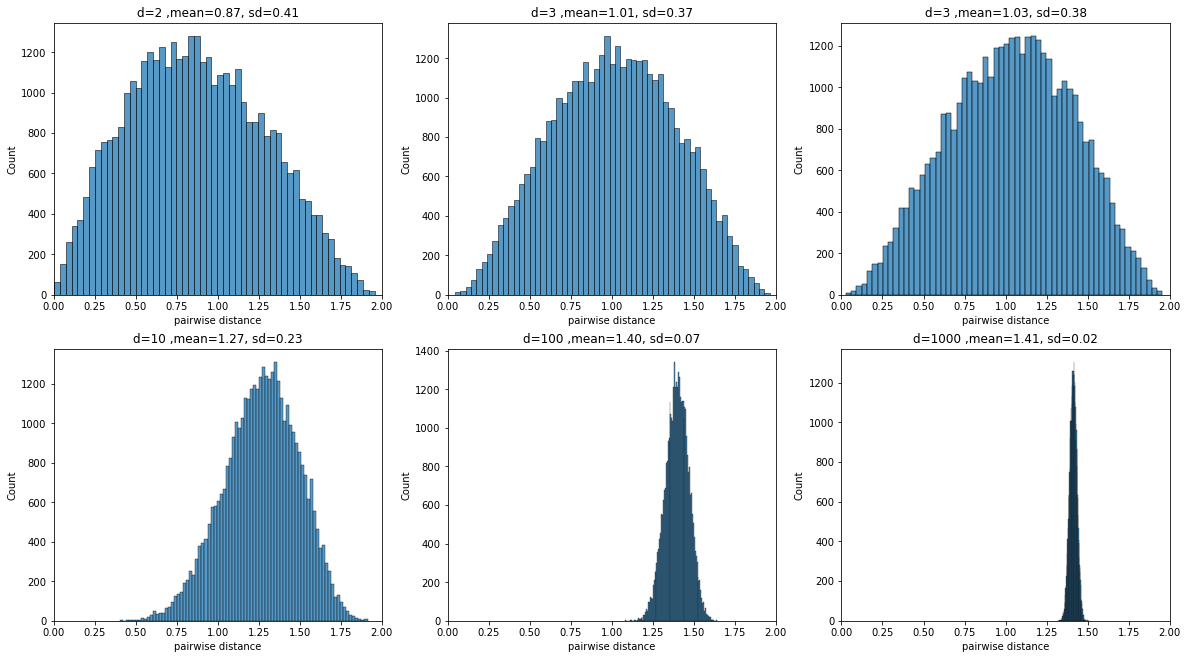

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,11))
i = 0
for ax in axs.reshape(-1): 
    points = sample_in_sphere(200, d[i])
    dists = pairwise_distances(points, metric='euclidean').flatten()
    dists = dists[dists != 0.0] # filter out D_ii
    i += 1
    
    df = pd.DataFrame(data={'pairwise distance': dists})
    sns.histplot(ax=ax, data=df, x="pairwise distance", kde=False)
    ax.set_title('d=%i ,mean=%.2f, sd=%.2f' %(d[i-1], np.mean(dists), np.var(dists)**0.5))
    ax.set_xlim(0, 2)

Here we see a similar "concentration" effect as the dimension gets large, similar to what we saw before for distances from the origin. Note, however, that here the pairwise distances are concentrating around $1.41$, and not $1.0$ as we had before.